# Problem 1

### Getting familiar with loading, visualizing and operating on multivariate data

A Hess diagram is a 2D plot coded by a third quantity.

Here's an example from the [astroML documentation](https://www.astroml.org/examples/datasets/plot_SDSS_SSPP.html) showing the temperature and surface gravity (how strongly the star would pull on you if you could stand on it's surface, including the effect of rotation), color coded on the left by density, and on the right by metallicity (measured here as the ratio of iron to hydrogen) with density contours.


<img src="https://www.astroml.org/_images/plot_SDSS_SSPP_1.png">

From http://das.sdss.org/va/stripe_82_variability/SDSS_82_public/, download eight HLC\*fits.gz files (and recall how you can use `astropy.io.fits` to load these)

The HLC files are each different bands on the sky.

For each HLC file, separate stars and galaxies by using the `MEAN_OBJECT_TYPE` column and making a cut with value > 5 to find stars.

For each HLC file, and separately for stars and galaxies make a 3-panel plot.

In the left plot show `r` vs `g-i` color coded by density (recall we did this with `seaborn`'s `jointplot`, but you can use whatever).

Estimate a bivariate distribution for `density(r, g-i)` this sample (recall we did with `seaborn`'s `jointplot` use `kde`, but you can use whatever).

In the middle and right panel, again plot `r` vs `g-i`, but now color-coded by proper motion in RA, and Dec. Overlay the density contors.

Comment on the structure in stars vs galaxies, and the evolution with position on the sky in each HLC.


In [93]:
import sys, os
import numpy as np
import seaborn as sns
import astropy.io.fits as fits
import matplotlib.pyplot as plt
%matplotlib inline

In [191]:
# READ FILES

# data directory
hlc_dir = '/Users/colin/astr596/ast596_2020_Spring/data/01/hlc'

# setup arrays
x_stars_arr = []
y_stars_arr = []
x_galaxies_arr = []
y_galaxies_arr = []
stars_ra = []
stars_dec = []
galaxies_ra = []
galaxies_dec = []
names = []

# loop through files in directory
for i in os.listdir(hlc_dir):
    # read file
    file_path = os.path.join(hlc_dir,i)
    hdul = fits.open(file_path)
    data = hdul[1].data
    # get stars
    stars = data[data['MEAN_OBJECT_TYPE'] > 5]
    galaxies = data[data['MEAN_OBJECT_TYPE'] <= 5]
    # get star mag (ugriz)
    stars_g = stars['MEAN_PSFMAG'][:,1]
    stars_r = stars['MEAN_PSFMAG'][:,2]
    stars_i = stars['MEAN_PSFMAG'][:,3]
    stars_ra.append(stars['RA_PM'])
    stars_dec.append(stars['DEC_PM'])
    # get galaxy mag (ugriz)
    galaxies_g = galaxies['MEAN_PSFMAG'][:,1]
    galaxies_r = galaxies['MEAN_PSFMAG'][:,2]
    galaxies_i = galaxies['MEAN_PSFMAG'][:,3]
    galaxies_ra.append(galaxies['RA_PM'])
    galaxies_dec.append(galaxies['DEC_PM'])
    # save data to arrays
    x_stars_arr.append(stars_r)
    y_stars_arr.append(stars_g-stars_i)
    x_galaxies_arr.append(galaxies_r)
    y_galaxies_arr.append(galaxies_g-galaxies_i)
    names.append(i)

In [476]:
from astropy.stats import sigma_clip

# REMOVE OUTLIERS
s = 3

# setup clipped arrays
x_stars_arr_clip = []
y_stars_arr_clip = []
x_galaxies_arr_clip = []
y_galaxies_arr_clip = []
stars_ra_clip = []
stars_dec_clip = []
galaxies_ra_clip = []
galaxies_dec_clip = []


# clip stars 
for i in range(len(x_stars_arr)):
    # clip x
    mask,lower,upper = sigma_clip(x_stars_arr[i], sigma=s, return_bounds=True)
    mask_x = (x_stars_arr[i]<upper) & (x_stars_arr[i]>lower)
    
    # clip y
    mask,lower,upper = sigma_clip(y_stars_arr[i], sigma=s, return_bounds=True)
    mask_y = (y_stars_arr[i]<upper) & (y_stars_arr[i]>lower)
    
    x_stars_arr_clip.append(x_stars_arr[i][mask_x & mask_y])
    y_stars_arr_clip.append(y_stars_arr[i][mask_x & mask_y])
    
    # clip ra and dec
    stars_ra_clip.append(stars_ra[i][mask_x & mask_y])
    stars_dec_clip.append(stars_dec[i][mask_x & mask_y])
    
s = 2
    
# clip galaxies 
for i in range(len(x_galaxies_arr)):
    # clip x
    mask,lower,upper = sigma_clip(x_galaxies_arr[i], sigma=s, return_bounds=True)
    mask_x = (x_galaxies_arr[i]<upper) & (x_galaxies_arr[i]>lower)
    
    # clip y
    mask,lower,upper = sigma_clip(y_galaxies_arr[i], sigma=s, return_bounds=True)
    mask_y = (y_galaxies_arr[i]<upper) & (y_galaxies_arr[i]>lower)
    
    x_galaxies_arr_clip.append(x_galaxies_arr[i][mask_x & mask_y])
    y_galaxies_arr_clip.append(y_galaxies_arr[i][mask_x & mask_y])
    
    # clip ra and dec
    galaxies_ra_clip.append(galaxies_ra[i][mask_x & mask_y])
    galaxies_dec_clip.append(galaxies_dec[i][mask_x & mask_y])

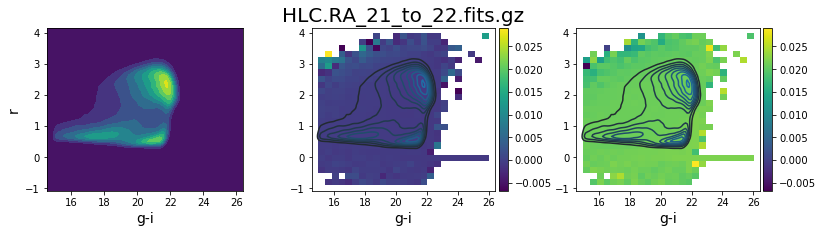

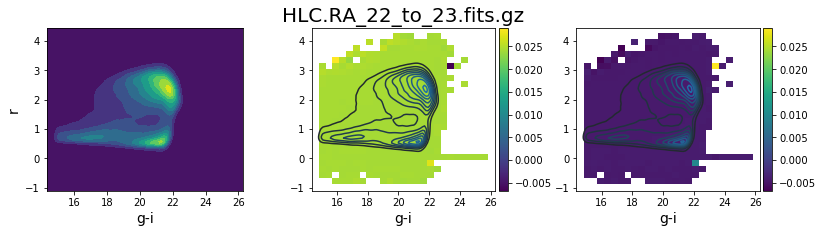

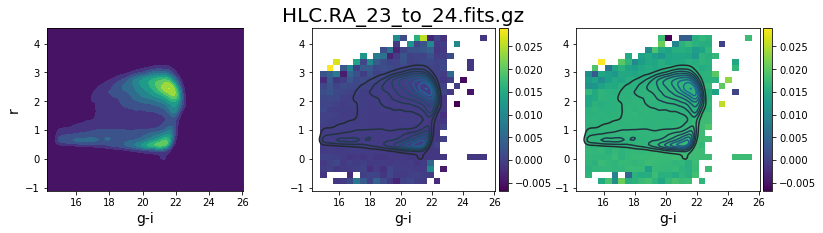

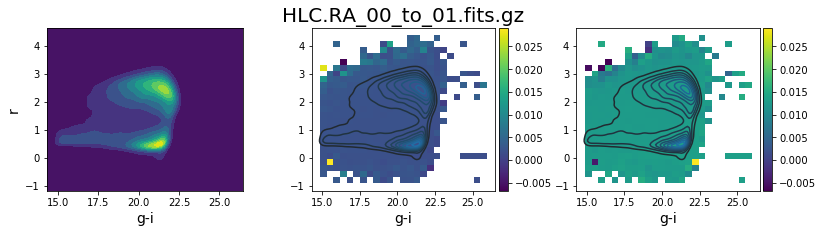

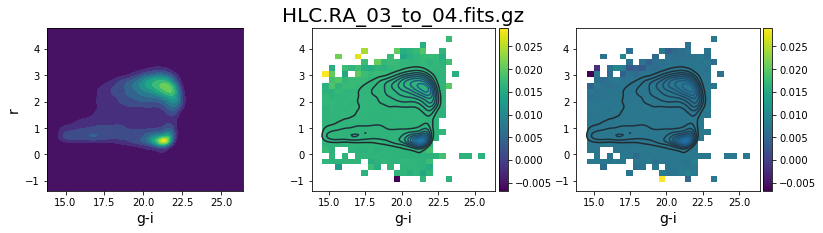

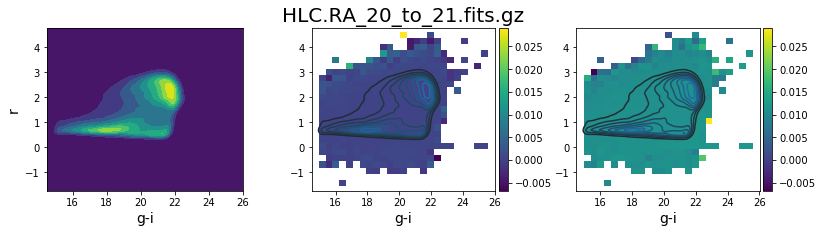

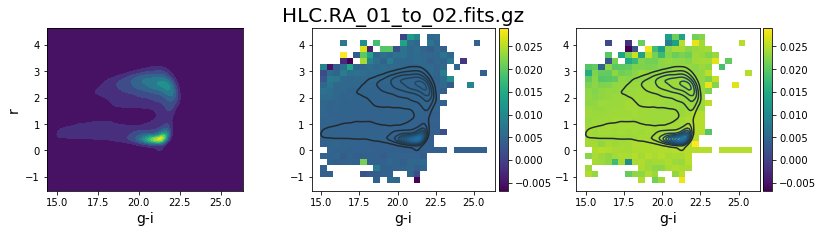

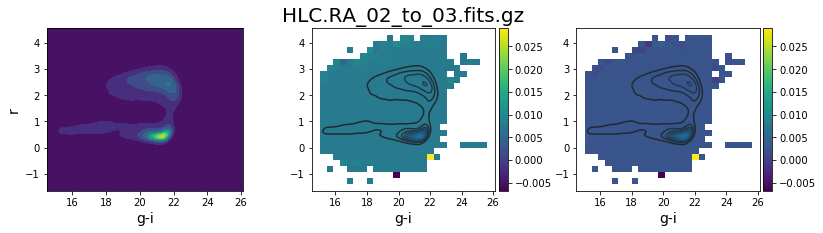

In [494]:
# PLOT STARS
from matplotlib import cm
from astroML.stats import binned_statistic_2d
from mpl_toolkits.axes_grid1 import make_axes_locatable

# plotting loop
every = 1 # to speed up test
for i in range(len(x_stars_arr_clip)):
    # plot
    fig, axs = plt.subplots(1,3,figsize=(13,3))
    # left panel
    sns.kdeplot(x_stars_arr_clip[i][::every], y_stars_arr_clip[i][::every], kind="kde", shade=True, ax=axs[0], cmap='viridis')
    axs[0].set_xlabel('g-i',fontsize=14)
    axs[0].set_ylabel('r',fontsize=14)
    xlim = axs[0].get_xlim()
    ylim = axs[0].get_ylim()
    # center panel
    # follow astroML 
    N, xedges, yedges = binned_statistic_2d(x_stars_arr_clip[i], y_stars_arr_clip[i], stars_ra_clip[i],
                                        'median', bins=25)
    axs[1].imshow(N.T, origin='lower',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           aspect='auto', interpolation='nearest', cmap='viridis')
    axs[1].set_xlim(xlim)
    axs[1].set_ylim(ylim)
    sns.kdeplot(x_stars_arr_clip[i][::every], y_stars_arr_clip[i][::every], c='k', kind="kde", shade=False, ax=axs[1])
    axs[1].set_xlabel('g-i',fontsize=14)
    axs[1].set_title(names[i],fontsize=20)
    # color bar
    divider = make_axes_locatable(axs[1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    # right panel
    N, xedges, yedges = binned_statistic_2d(x_stars_arr_clip[i], y_stars_arr_clip[i], stars_dec_clip[i],
                                        'median', bins=25)
    axs[2].imshow(N.T, origin='lower',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           aspect='auto', interpolation='nearest', cmap='viridis')
    axs[2].set_xlim(xlim)
    axs[2].set_ylim(ylim)
    sns.kdeplot(x_stars_arr_clip[i][::every], y_stars_arr_clip[i][::every], c='k', kind="kde", shade=False, ax=axs[2])
    axs[2].set_xlabel('g-i',fontsize=14)
    # color bar
    divider = make_axes_locatable(axs[2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    plt.subplots_adjust(wspace=0.35)

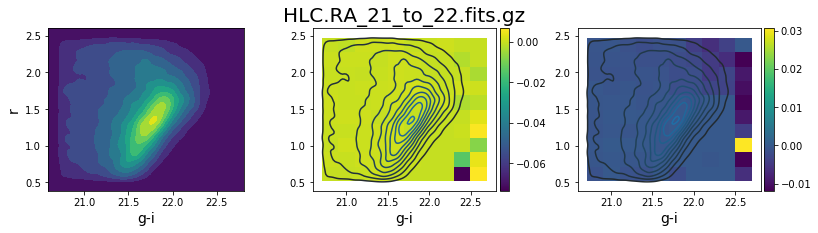

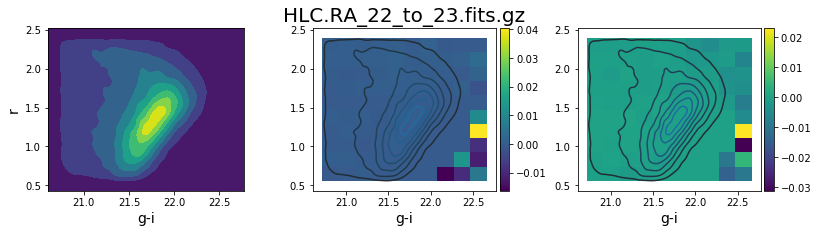

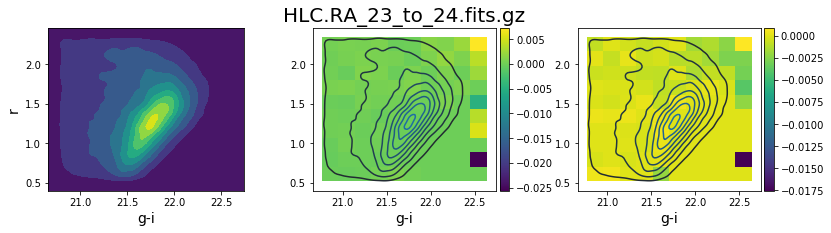

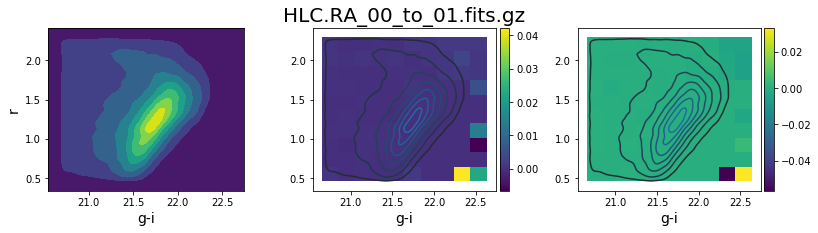

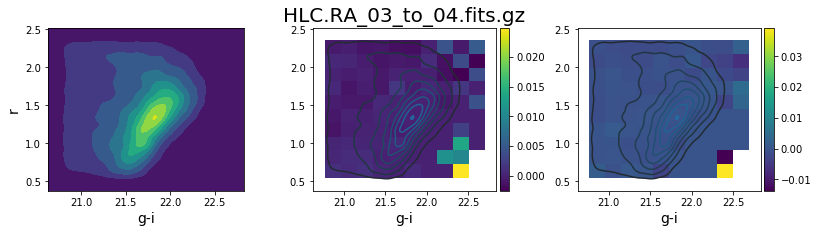

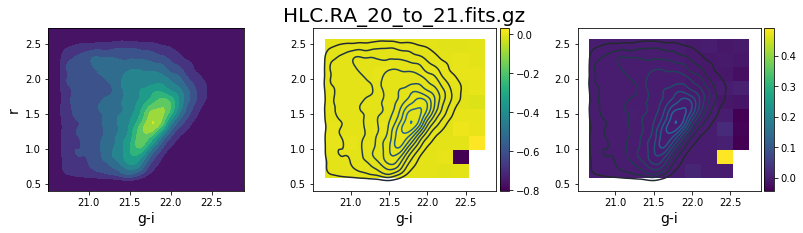

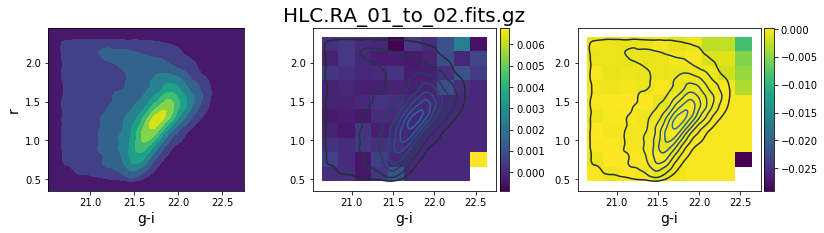

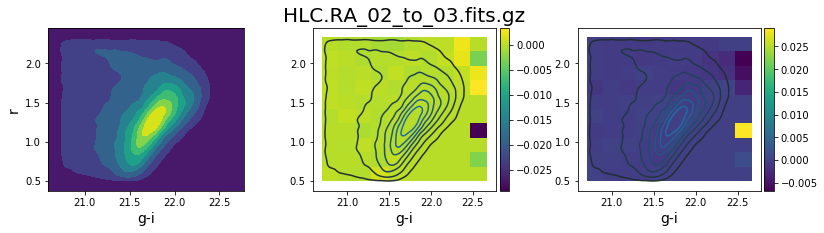

In [495]:

# PLOT GALAXIES
for i in range(len(x_stars_arr_clip)):
    # plot
    fig, axs = plt.subplots(1,3,figsize=(13,3))
    # left panel
    sns.kdeplot(x_galaxies_arr_clip[i][::every], y_galaxies_arr_clip[i][::every], kind="kde", shade=True, ax=axs[0], cmap='viridis')
    axs[0].set_xlabel('g-i',fontsize=14)
    axs[0].set_ylabel('r',fontsize=14)
    xlim = axs[0].get_xlim()
    ylim = axs[0].get_ylim()
    # center panel
    # follow astroML 
    N, xedges, yedges = binned_statistic_2d(x_galaxies_arr_clip[i], y_galaxies_arr_clip[i], galaxies_ra_clip[i],
                                        'median', bins=10)
    im = axs[1].imshow(N.T, origin='lower',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           aspect='auto', interpolation='nearest', cmap='viridis')
    axs[1].set_xlim(xlim)
    axs[1].set_ylim(ylim)
    sns.kdeplot(x_galaxies_arr_clip[i][::every], y_galaxies_arr_clip[i][::every], c='k', kind="kde", shade=False, ax=axs[1])
    axs[1].set_xlabel('g-i',fontsize=14)
    axs[1].set_title(names[i],fontsize=20)
    divider = make_axes_locatable(axs[1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical');
    # right panel
    N, xedges, yedges = binned_statistic_2d(x_galaxies_arr_clip[i], y_galaxies_arr_clip[i], galaxies_dec_clip[i],
                                        'median', bins=10)
    im = axs[2].imshow(N.T, origin='lower',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           aspect='auto', interpolation='nearest', cmap='viridis')
    axs[2].set_xlim(xlim)
    axs[2].set_ylim(ylim)
    sns.kdeplot(x_galaxies_arr_clip[i][::every], y_galaxies_arr_clip[i][::every], c='k', kind="kde", shade=False, ax=axs[2])
    axs[2].set_xlabel('g-i',fontsize=14)
    # color bar
    divider = make_axes_locatable(axs[2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    plt.subplots_adjust(wspace=0.35)

### Discussion

The distributions of stars is double peaked and has a mean roughly at r=2 and g-i=21 (estimating by eye) and standard deviation of r=2 and g-i=2 roughly. The galaxies have a mean of roughly r=1.2 and g-i=21.75 with standard deviation of r=0.75 and g-i=0.5.

There are two populations of stars, because the distribution is double peaked. One population is bluer and the other population is redder/older. There is a clear evolution versus RA and dec. We are seeing the stars in the Milky Way projected onto Celestial coordinates. The galactic center is at 17h, -29d (roughly), and the redder population is in the halo and center of the galaxy while the bluer population is along to the disk.

By comparison, we only see one population of galaxies. We should no see a large variation accross RA, dec except if this is caused by reddening from the galactic dust.

# Problem 2

### Comparing distributions to a standard normal distribution

Load the `IntroStat_demo.csv` file in the data directory (use `pandas` or `astropy` or whatever you like).

Estimate the sample mean and variance of the suspiciously named `mag.outlier` column.

Make a Q-Q plot of the `mag.outlier` column and over plot a line with `Y = Mean + Sigma*X` on it. 

Calculate the values of the first and third quartiles, and use some linear algebra to figure out the equation of a line passing through them (google line 2 point form if you need a refresher on the linear algebra)

Overplot that line passing through the data.

Now try the same thing with `mag.het`. Describe what you found?

What happens if you rescale the data? Subtract of the sample mean of `mag.het` and divide by `mag.het.error`. Now repeat the Q-Q plot with this quantity. 

Describe what's going on.

In [498]:
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm

# read file 
df = pd.read_csv('/Users/colin/astr596/ast596_2020_Spring/data/01/IntroStat_demo.csv')

In [505]:
def prob2(data):
    
    median = np.median(data)
    std = np.std(data)
    
    print('median = ', median)
    print('std = ', std)

    sm.qqplot(data, color='k', marker='.')
    plt.title('QQ plot')
    # plot line
    nvals = np.arange(-2.5, 2.5, 0.01)
    y = median + std*nvals
    plt.plot(nvals, y, '--', color='C2', lw=2, label='Using median/std')

    # Get 1st and 3rd quantile
    mag_arr = np.array(data)
    mag_arr = np.sort(mag_arr)

    # Use 0.25 and 0.75 as the x positions
    y1 = np.quantile(data, 0.25)
    x1 = st.norm.ppf(0.25)
    y2 = np.quantile(data, 0.75)
    x2 = idx_nearest(mag_arr, y2)
    x2 = st.norm.ppf(0.75)
    # plot line
    nvals = np.arange(-2.5, 2.5, 0.01)

    y = (y2-y1)/(x2-x1)*(nvals-x1) + y1
    plt.plot(nvals, y, '--',c ='red', lw=2, label='Using IQR')
    plt.legend()

median =  18.5537119067762
std =  0.07128179566341637


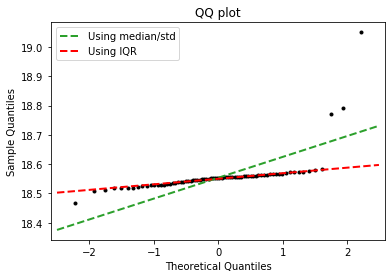

In [506]:
prob2(df['mag.outlier'])

median =  18.553247466489353
std =  0.04529648708274651


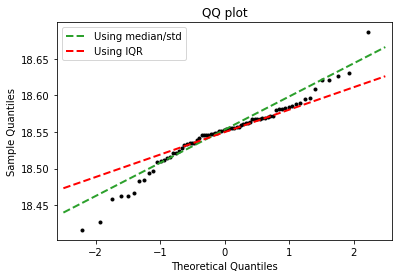

In [507]:
prob2(df['mag.het'])

### Discusssion


Mag.het has fewer outliers than Mag.outlier. This means the linear fit is a better fit to the data because the outliers skew the result.

median =  0.1262360475379429
std =  0.9074942284932059


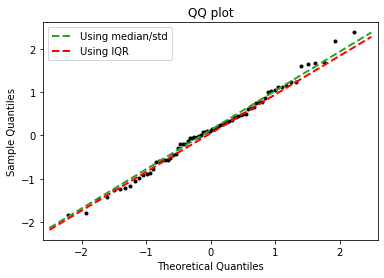

In [508]:
mean = np.mean(df['mag.het'])
prob2((df['mag.het'] - mean)/df['mag.het.error'])

### Discusssion

If the points on the QQ plot are linear, it means both qunatiles are drawn from the same distribution.

The rescaled plot is the best fit because we have now taken into account the errors on each point which will bias our previous result. Generally, the line fit IQR less sensitive to the outliers and the fit is better.

# Problem 3

The demo data set for this part is the Wesenheit index of the OGLE-III fundamental-mode and first overtone classical Cepheids. 

These stars are awesome because you can use them to measure distances. Here's a nice [youtube video](https://www.youtube.com/watch?v=iyisAjHdhas) on these stars.

You'll try to estimate their period-luminosity relationship. 

The Wesenheit index is defined as `W = I - 1.55(V - I)`, and its main advantage over using simply the I or V photometry is that it is insensitive to extinction. It is denoted by 'W' among the data columns. 

Other columns are 'name', the identifier of the star; 'RA0' (in decimal hours) and 'Decl0' (in decimal degrees), celestial coordinates; 'Mode', the mode of the Cepheid ('F' indicates fundamental-mode, '1' indicates first overtone star); 'Cloud', indicating which Magellanic Cloud the star belongs to; 'logP1', the base-10 logarithm of the period in days; 'VI', the colour V-I.


Split the data into LMC and SMC, and then again by mode F and 1, and plot the `W` on the y-axis vs `log(P1)` on x.
Fit or estimate straight lines to each of the four samples (you can use `statsmodels` `astropy` `scipy` `numpy`....)
(Yes, we've not covered fitting straight lines. That's OK.)

Compute the residuals of each sample to it's respective line. Do these residuals look like a normal distribution? If not, speculate on why (WATCH THE YOUTUBE VIDEO!)

Plot the residuals color coded by if they are positive or negative vs RA and Dec (just like a Hess diagram in Problem 1).

Finally, plot the residuals against the fitted `W` values, and just to anticipate the next homework assignment, also plot `log(P1) vs V-I`. Comment on what you are seeing.

In [427]:
# read file 
df = pd.read_csv('/Users/colin/astr596/ast596_2020_Spring/data/01/Cepheids.csv')

In [428]:
lmc = df[df['Cloud']=='LMC']
smc = df[df['Cloud']=='SMC']

In [429]:
lmcF = lmc[lmc['Mode']=='F']
lmc1 = lmc[lmc['Mode']=='1']

smcF = smc[smc['Mode']=='F']
smc1 = smc[smc['Mode']=='1']

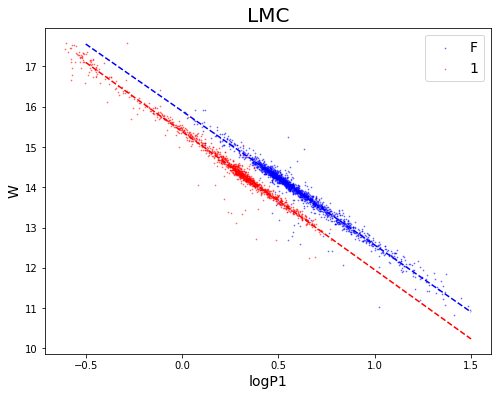

In [611]:
# plot
plt.figure(figsize=(8,6))
plt.scatter(lmcF['logP1'],lmcF['W'], alpha=0.5, s=.5, c='b', label='F')
plt.scatter(lmc1['logP1'],lmc1['W'], alpha=0.5, s=.5, c='r', label='1')
# fit lines
p = np.polyfit(lmcF['logP1'],lmcF['W'],1)
ypF = np.poly1d(p) 
x = np.linspace(-0.5,1.5,100)
plt.plot(x, ypF(x), c='b', linestyle='dashed')
p = np.polyfit(lmc1['logP1'],lmc1['W'],1)
yp1 = np.poly1d(p) 
x = np.linspace(-0.5,1.5,100)
plt.plot(x, yp1(x), c='r', linestyle='dashed')
plt.title('LMC',fontsize=20)
plt.xlabel('logP1',fontsize=14)
plt.ylabel('W',fontsize=14)
plt.legend(fontsize=14)

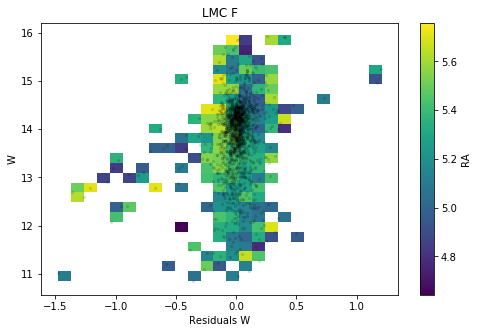

In [596]:
# RESIDUALS VS W
res_w = lmcF['W'] - ypF(lmcF['logP1']) # W residuals

plt.figure(figsize=(8,5))
ax = plt.gca()

N, xedges, yedges = binned_statistic_2d(res_w, lmcF['W'], lmcF['RA0'],
                                        'median', bins=25)
im = ax.imshow(N.T, origin='lower',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           aspect='auto', interpolation='nearest', cmap='viridis')

plt.scatter(res_w, lmcF['W'], color='k', s=5, alpha=0.1)
plt.xlabel('Residuals W')
plt.ylabel('W')
plt.title('LMC F')
plt.colorbar(im, label='RA')

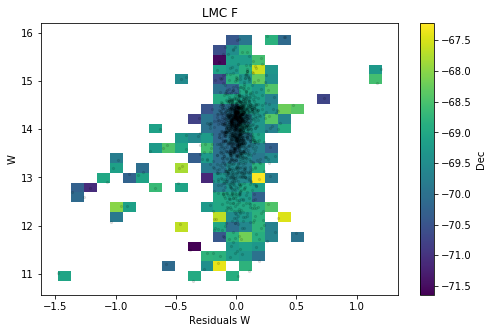

In [612]:
# RESIDUALS VS W
res_w = lmcF['W'] - ypF(lmcF['logP1']) # W residuals

plt.figure(figsize=(8,5))
ax = plt.gca()

N, xedges, yedges = binned_statistic_2d(res_w, lmcF['W'], lmcF['Decl0'],
                                        'median', bins=25)
im = ax.imshow(N.T, origin='lower',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           aspect='auto', interpolation='nearest', cmap='viridis')

plt.scatter(res_w, lmcF['W'], color='k', s=5, alpha=0.1)
plt.xlabel('Residuals W')
plt.ylabel('W')
plt.title('LMC F')
plt.colorbar(im, label='Dec')

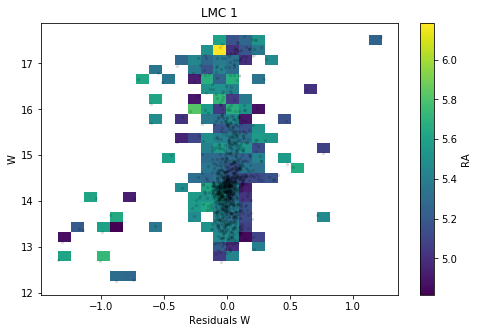

In [613]:
# RESIDUALS VS W
res_w = lmc1['W'] - yp1(lmc1['logP1']) # W residuals

plt.figure(figsize=(8,5))
ax = plt.gca()

N, xedges, yedges = binned_statistic_2d(res_w, lmc1['W'], lmc1['RA0'],
                                        'median', bins=25)
im = ax.imshow(N.T, origin='lower',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           aspect='auto', interpolation='nearest', cmap='viridis')

plt.scatter(res_w, lmc1['W'], color='k', s=5, alpha=0.1)
plt.xlabel('Residuals W')
plt.ylabel('W')
plt.title('LMC 1')
plt.colorbar(im, label='RA')

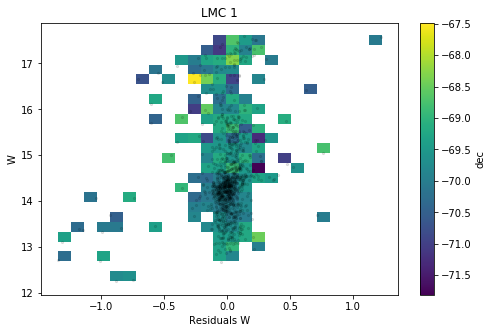

In [614]:
# RESIDUALS VS W
res_w = lmc1['W'] - yp1(lmc1['logP1']) # W residuals

plt.figure(figsize=(8,5))
ax = plt.gca()

N, xedges, yedges = binned_statistic_2d(res_w, lmc1['W'], lmc1['Decl0'],
                                        'median', bins=25)
im = ax.imshow(N.T, origin='lower',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           aspect='auto', interpolation='nearest', cmap='viridis')

plt.scatter(res_w, lmc1['W'], color='k', s=5, alpha=0.1)
plt.xlabel('Residuals W')
plt.ylabel('W')
plt.title('LMC 1')
plt.colorbar(im, label='dec')

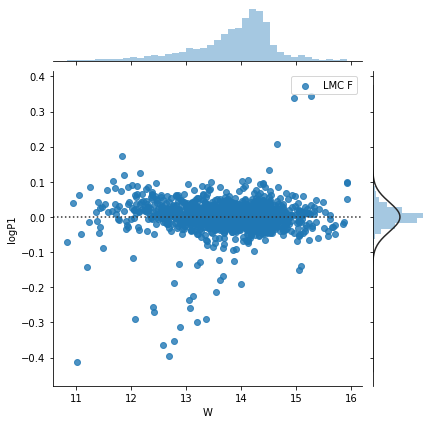

In [509]:
# RESIDUALS (Use Seaborn):
sns.jointplot(lmcF['W'],lmcF['logP1'], kind='residual', label='LMC F')
plt.legend()

([0, 1], [0, 0])


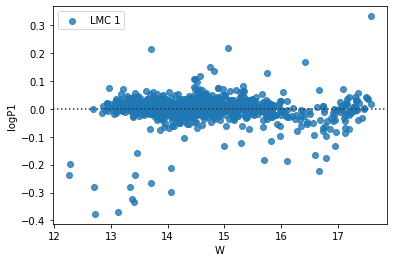

In [541]:
# RESIDUALS (Use Seaborn):
sns.residplot(lmc1['W'],lmc1['logP1'], label='LMC 1')
print(plt.gca().lines[0].get_data())
plt.legend()

In [ ]:
sns.jointplot(lmc1['W'],lmc1['logP1'], kind='residual', label='LMC 1', color=)
plt.legend()

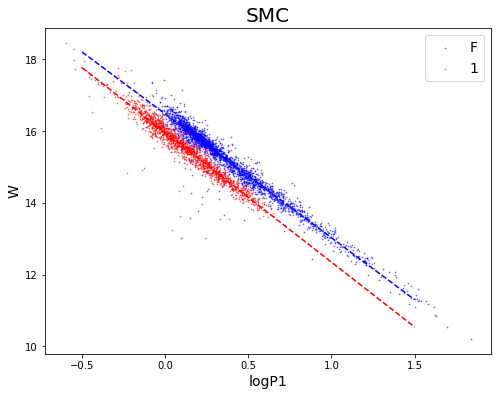

In [598]:
# plot
plt.figure(figsize=(8,6))
plt.scatter(smcF['logP1'],smcF['W'], alpha=0.5, s=.5, c='b', label='F')
plt.scatter(smc1['logP1'],smc1['W'], alpha=0.5, s=.5, c='r', label='1')
# fit lines
p = np.polyfit(smcF['logP1'],smcF['W'],1)
yp1 = np.poly1d(p) 
x = np.linspace(-0.5,1.5,100)
plt.plot(x, yp1(x), c='b', linestyle='dashed')
p = np.polyfit(smc1['logP1'],smc1['W'],1)
ypF = np.poly1d(p) 
x = np.linspace(-.5,1.5,100)
plt.plot(x, ypF(x), c='r', linestyle='dashed')
plt.title('SMC',fontsize=20)
plt.xlabel('logP1',fontsize=14)
plt.ylabel('W',fontsize=14)
plt.legend(fontsize=14)

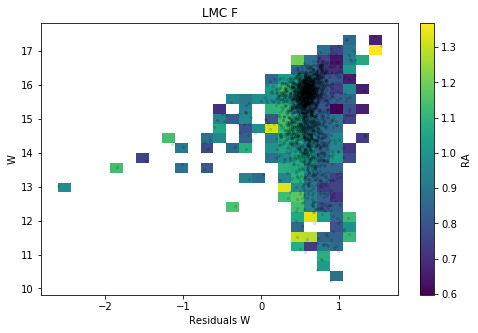

In [600]:
# RESIDUALS VS W
res_w = smcF['W'] - ypF(smcF['logP1']) # W residuals

plt.figure(figsize=(8,5))
ax = plt.gca()

N, xedges, yedges = binned_statistic_2d(res_w, smcF['W'], smcF['RA0'],
                                        'median', bins=25)
im = ax.imshow(N.T, origin='lower',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           aspect='auto', interpolation='nearest', cmap='viridis')

plt.scatter(res_w, smcF['W'], color='k', s=5, alpha=0.1)
plt.xlabel('Residuals W')
plt.ylabel('W')
plt.title('LMC F')
plt.colorbar(im, label='RA')

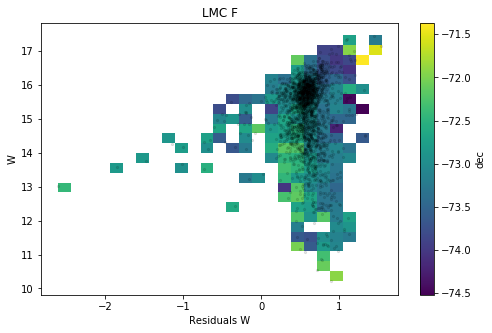

In [608]:
# RESIDUALS VS W
res_w = smcF['W'] - ypF(smcF['logP1']) # W residuals

plt.figure(figsize=(8,5))
ax = plt.gca()

N, xedges, yedges = binned_statistic_2d(res_w, smcF['W'], smcF['Decl0'],
                                        'median', bins=25)
im = ax.imshow(N.T, origin='lower',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           aspect='auto', interpolation='nearest', cmap='viridis')

plt.scatter(res_w, smcF['W'], color='k', s=5, alpha=0.1)
plt.xlabel('Residuals W')
plt.ylabel('W')
plt.title('LMC F')
plt.colorbar(im, label='dec')

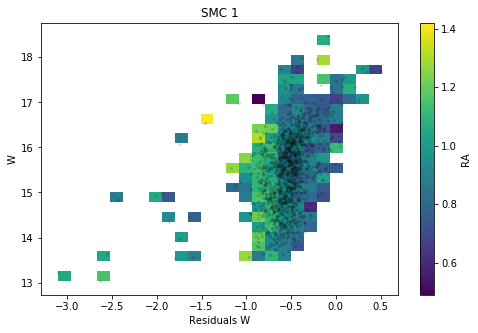

In [601]:
# RESIDUALS VS W
res_w = smc1['W'] - yp1(smc1['logP1']) # W residuals

plt.figure(figsize=(8,5))
ax = plt.gca()

N, xedges, yedges = binned_statistic_2d(res_w, smc1['W'], smc1['RA0'],
                                        'median', bins=25)
im = ax.imshow(N.T, origin='lower',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           aspect='auto', interpolation='nearest', cmap='viridis')

plt.scatter(res_w, smc1['W'], color='k', s=5, alpha=0.1)
plt.xlabel('Residuals W')
plt.ylabel('W')
plt.title('SMC 1')
plt.colorbar(im, label='RA')

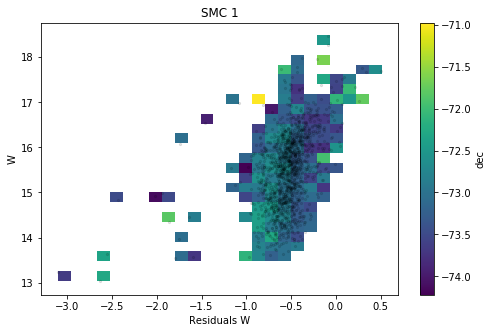

In [610]:
# RESIDUALS VS W
res_w = smc1['W'] - yp1(smc1['logP1']) # W residuals

plt.figure(figsize=(8,5))
ax = plt.gca()

N, xedges, yedges = binned_statistic_2d(res_w, smc1['W'], smc1['Decl0'],
                                        'median', bins=25)
im = ax.imshow(N.T, origin='lower',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           aspect='auto', interpolation='nearest', cmap='viridis')

plt.scatter(res_w, smc1['W'], color='k', s=5, alpha=0.1)
plt.xlabel('Residuals W')
plt.ylabel('W')
plt.title('SMC 1')
plt.colorbar(im, label='dec')

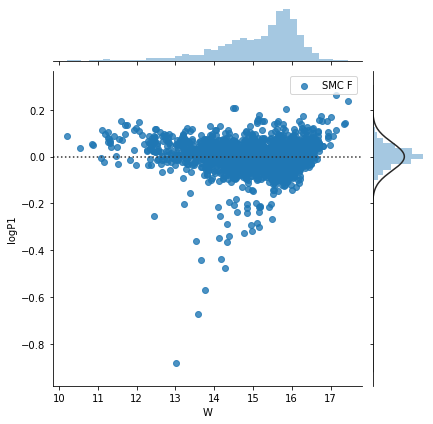

In [511]:
# RESIDUALS (Use Seaborn):
ra_norm = smcF['RA0']/np.max(smcF['RA0'])
sns.jointplot(smcF['W'],smcF['logP1'],kind='residual',label='SMC F')
plt.legend()

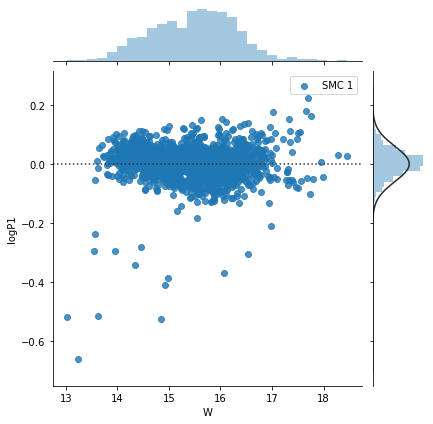

In [512]:
sns.jointplot(smc1['W'],smc1['logP1'],kind='residual',label='SMC 1')
plt.legend()

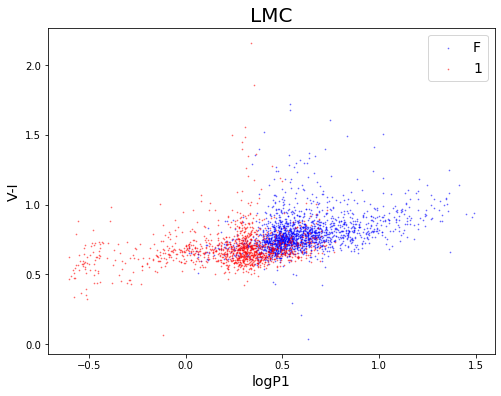

In [515]:
# plot
plt.figure(figsize=(8,6))


plt.scatter(lmcF['logP1'],lmcF['VI'], alpha=0.5, s=.5, c='b', label='F')
plt.scatter(lmc1['logP1'],lmc1['VI'], alpha=0.5, s=.5, c='r', label='1')
# fit lines
p = np.polyfit(lmcF['logP1'],lmcF['W'],1)
p = np.polyfit(lmc1['logP1'],lmc1['W'],1)
plt.title('LMC',fontsize=20)
plt.xlabel('logP1',fontsize=14)
plt.ylabel('V-I',fontsize=14)
plt.legend(fontsize=14)

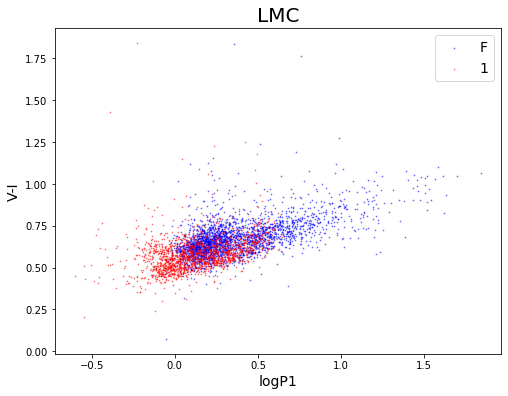

In [516]:
# plot
plt.figure(figsize=(8,6))


plt.scatter(smcF['logP1'],smcF['VI'], alpha=0.5, s=.5, c='b', label='F')
plt.scatter(smc1['logP1'],smc1['VI'], alpha=0.5, s=.5, c='r', label='1')
# fit lines
p = np.polyfit(smcF['logP1'],smcF['W'],1)
p = np.polyfit(smc1['logP1'],smc1['W'],1)
plt.title('LMC',fontsize=20)
plt.xlabel('logP1',fontsize=14)
plt.ylabel('V-I',fontsize=14)
plt.legend(fontsize=14)

### Discusssion

The residuals on log P are more sharply peaked than a Gaussian and has some outliers which tend to skew to shorter periods. This could be due to an distribution in periods. But it may more likely be due to an observational bias because it is difficult to measure longer periods. There is no large difference between the SMC and LMC. In general, the log period-luminosity relation is linear.

There is a correlation between period and color V-I. Redder Cepheids have longer periods on average, which is an interesting result but may just be due to sensitivy to extinction and not an intrinsic astrophysical result. The F modes also tend to have larger periods than the first mode.